In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

mnist = input_data.read_data_sets('../Basic TF & things/mnist/', one_hot=True)

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Extracting ../Basic TF & things/mnist/train-images-idx3-ubyte.gz
Extracting ../Basic TF & things/mnist/train-labels-idx1-ubyte.gz
Extracting ../Basic TF & things/mnist/t10k-images-idx3-ubyte.gz
Extracting ../Basic TF & things/mnist/t10k-labels-idx1-ubyte.gz


# Select GPU to be used

In [2]:
device_type = '/gpu:0'

# Define Params and Network Params

In [3]:
#Params
learning_rate = 0.001
epochs = 20
batch_size = 100
display_step = 5
keep = 0.7

#Network Params
n_input = 784                           #input features (imageshape 28*28)
n_classes = mnist.train.labels.shape[1] #number of output ditgits 0 -> 9

#Placeholder
x = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes])
keep_prob = tf.placeholder(dtype=tf.float32)

#Weights and Biases
stddev = 0.1

weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=[3,3,1,64], stddev=stddev)),
    'wc2': tf.Variable(tf.truncated_normal(shape=[3,3,64,128], stddev=stddev)),
    'wd1': tf.Variable(tf.truncated_normal(shape=[7*7*128, 1024], stddev=stddev)),
    'wd2': tf.Variable(tf.truncated_normal(shape=[1024, n_classes], stddev=stddev))
}

biases = {
    'bc1': tf.Variable(tf.random_normal(shape=[64], stddev=stddev)),
    'bc2': tf.Variable(tf.random_normal(shape=[128], stddev=stddev)),
    'bd1': tf.Variable(tf.random_normal(shape=[1024], stddev=stddev)),
    'bd2': tf.Variable(tf.random_normal(shape=[n_classes], stddev=stddev))
}

# Define CNN basic function

In [4]:
def conv_basic(x, weights, biases, keep_prob):
    #reshape input from [784] -> [-1, 28, 28, 1]
    input_r = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    #Conv layer 1
    conv1 = tf.nn.conv2d(input_r, filter=weights['wc1'], strides=[1,1,1,1], padding='SAME')
    mean, variance = tf.nn.moments(conv1, axes=[0,1,2]) #Calculate the mean and variance of the conv1, more than 1-D axes = [0,1,2], 1-D axes = [0]
    conv1 = tf.nn.batch_normalization(conv1, mean=mean, variance=variance, offset=0, scale=1, variance_epsilon=0.0001)
    conv1 = tf.nn.relu(tf.nn.bias_add(conv1, bias=biases['bc1']))
    pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    pool1_dr = tf.nn.dropout(pool1, keep_prob=keep_prob)
    
    #Conv layer 2
    conv2 = tf.nn.conv2d(pool1_dr, filter=weights['wc2'], strides=[1,1,1,1], padding='SAME')
    mean, variance = tf.nn.moments(conv2, axes=[0,1,2])
    conv2 = tf.nn.batch_normalization(conv2, mean=mean, variance=variance, offset=0, scale=1, variance_epsilon=0.0001)
    conv2 = tf.nn.relu(tf.nn.bias_add(conv2, bias=biases['bc2']))
    pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    pool2_dr = tf.nn.dropout(pool2, keep_prob=keep_prob)
    
    #Vectorize
    dense = tf.reshape(pool2_dr, shape=[-1, weights['wd1'].get_shape().as_list()[0]])
    
    #Fully connected layer 1
    fc1 = tf.nn.relu(tf.add(tf.matmul(dense, weights['wd1']), biases['bd1']))
    fc1_dr = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    #Fully connected layer 2
    out = tf.add(tf.matmul(fc1_dr, weights['wd2']), biases['bd2'])
    
    #Return all the layers
    out = {
        'input_r': input_r,
        'conv1': conv1,
        'pool1': pool1,
        'pool1_dr': pool1_dr,
        'conv2': conv2,
        'pool2': pool2,
        'pool2_dr': pool2_dr,
        'dense': dense,
        'fc1': fc1,
        'fc1_dr': fc1_dr,
        'out': out,
    }
    
    return out

# Define other functions conputation graph

In [5]:
y_pred = conv_basic(x, weights, biases, keep_prob)['out']

#Define loss function and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#Define correct_pred and accuracry functions
correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

#Init function
init = tf.global_variables_initializer()

#Saver function to save model
save_step = 1
saver = tf.train.Saver(max_to_keep=3)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



# Training Phase

In [6]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [7]:
for epoch in range(epochs):
    avg_loss = 0
    total_batch = int(mnist.train.num_examples/batch_size)
    
    #Loop over all batches
    for i in range(total_batch):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        #Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: keep})
        
        #Compute avg loss
        avg_loss += sess.run(loss, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0}) / total_batch
        
    #Display logs per epoch step
    if epoch % display_step == 0:
        print('Epoch: %03d/%03d,     loss: %.4f' % (epoch, epochs, avg_loss))
        training_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
        print('-->    Training Accuracy: ', training_accuracy)
        print('-->    Test Accuracy: ', test_accuracy)
        
    #Save model
    if epoch % save_step == 0:
        saver.save(sess=sess, save_path= 'saved_models/cnn_mnist_basic.ckpt-' + str(epoch))
        
print('Last Accuracy for test set: ', test_accuracy)

Epoch: 000/020,     loss: 0.7004
-->    Training Accuracy:  0.97
-->    Test Accuracy:  0.9662
Epoch: 005/020,     loss: 0.0353
-->    Training Accuracy:  0.99
-->    Test Accuracy:  0.99
Epoch: 010/020,     loss: 0.0191
-->    Training Accuracy:  0.98
-->    Test Accuracy:  0.9906
Epoch: 015/020,     loss: 0.0099
-->    Training Accuracy:  1.0
-->    Test Accuracy:  0.9916
Last Accuracy for test set:  0.9916


# Build Confusion matrix

In [24]:
#Build Confusion matrix plot function

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
#y_test labels and predicted test labels from the model
y_test = mnist.test.labels
y_test = np.argmax(y_test, 1)

predicted = sess.run(y_pred, feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
predicted = np.argmax(predicted, 1)

In [27]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [28]:
predicted

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [30]:
cfs_matrix = confusion_matrix(y_pred=predicted, y_true=y_test)
cfs_matrix.shape

(10, 10)

Confusion matrix, without normalization
[[ 977    0    0    0    0    0    2    0    0    1]
 [   0 1133    0    0    0    0    1    0    1    0]
 [   1    1 1023    0    1    0    0    6    0    0]
 [   0    0    0 1004    0    4    0    1    1    0]
 [   0    0    1    0  976    0    3    0    0    2]
 [   2    0    0    2    0  887    1    0    0    0]
 [   5    2    0    0    1    3  947    0    0    0]
 [   0    4    2    0    0    0    0 1017    1    4]
 [   2    0    1    1    0    1    0    2  965    2]
 [   0    3    0    0    5    3    0    0    2  996]]


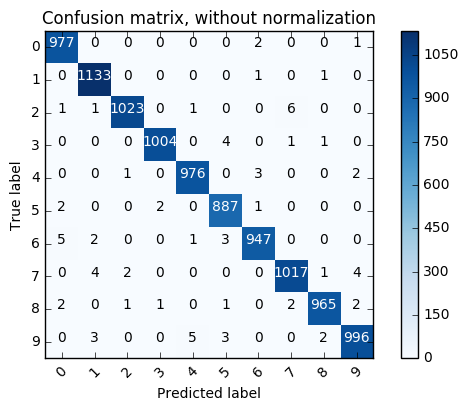

In [31]:
classes_name = np.array(['0','1','2','3','4','5','6','7','8','9',])

#Plot non_normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm=cfs_matrix, classes=classes_name, title='Confusion matrix, without normalization')